In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')
path = 'drive/MyDrive/ASD_Research/'
data = pd.read_csv(path + 'combined.csv')
x_vals = data.iloc[:, 0:14]
y_vals = data.iloc[:, 14]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MLPModel:
    def __init__(self, test_size, input_data, target_data, epochs, batch_size, learning_rate, dropout_rate, split_seed=None, model_seed=None):
        self.X = input_data  # Features
        self.y = target_data  # Target (binary: 0 or 1 for ASD)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.test_size = test_size
        self.split_seed = split_seed
        self.model_seed = model_seed
        self.feature_names = input_data.columns.tolist()
        self.scaler = MinMaxScaler(feature_range=(-1, 1))

        if self.split_seed is not None:
            np.random.seed(self.split_seed)
            random.seed(self.split_seed)

        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_scaled, self.y, test_size=self.test_size, random_state=self.split_seed
        )

        if self.model_seed is not None:
            tf.random.set_seed(self.model_seed)

        self.model = self._build_model()
        self.train_accuracies = []
        self.val_accuracies = []

    def _build_model(self):
        input_layer = Input(shape=(self.X_train.shape[1],))
        hidden_layer1 = Dense(256, activation='relu')(input_layer)
        dropout1 = Dropout(self.dropout_rate)(hidden_layer1)
        hidden_layer2 = Dense(64, activation='relu')(dropout1)
        dropout2 = Dropout(self.dropout_rate)(hidden_layer2)
        hidden_layer3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(self.dropout_rate)(hidden_layer3)
        output_layer = Dense(1, activation='sigmoid')(dropout3)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

        return model

    def train(self):
        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2, verbose=0,
        )
        self.train_accuracies = self.history.history['accuracy']
        self.val_accuracies = self.history.history['val_accuracy']

    def evaluate(self):
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        return accuracy


In [ ]:
mlp_model = MLPModel(
    input_data=x_vals,
    target_data=y_vals,
    test_size=0.2,
    epochs=100,
    batch_size=32,
    learning_rate=0.001,
    dropout_rate=0.7,
    model_seed = 4268,
    split_seed = 345712
)

print(mlp_model.model.summary())

mlp_model.train()
acc = mlp_model.evaluate()
print(acc)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,401 (87.50 KB)

 Trainable params: 22,401 (87.50 KB)

 Non-trainable params: 0 (0.00 B)

None
0.9402697682380676


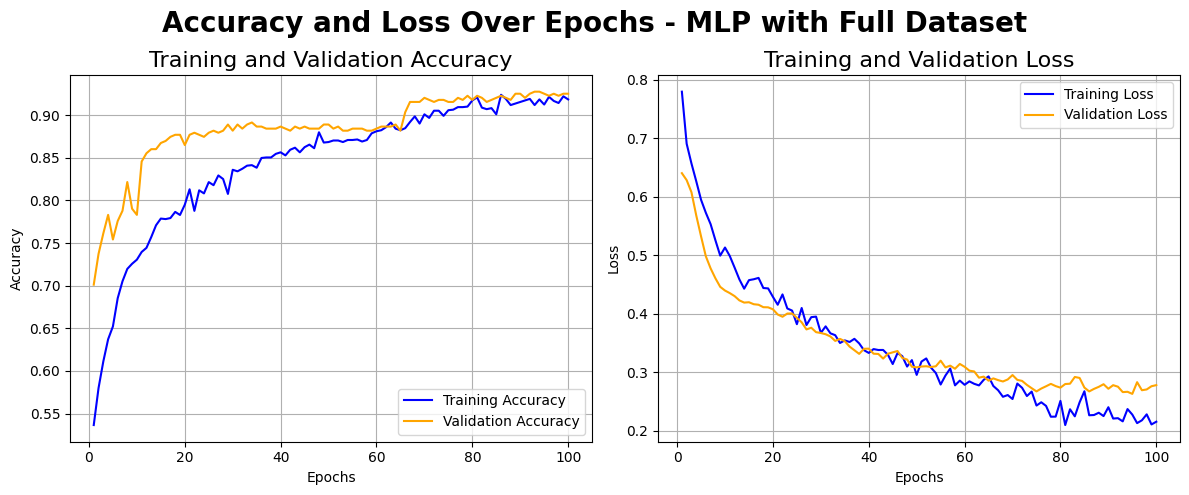

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy & Loss Over Epochs
def plot_training_curves(history):
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))

    # Add an overarching title for the entire figure
    plt.suptitle('Accuracy and Loss Over Epochs - MLP with Full Dataset', fontsize=20, fontweight='bold')  # Larger font size for the overall title

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy', fontsize=16)  # Title for the first subplot
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss', fontsize=16)  # Title for the second subplot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust to make room for the overarching title
    plt.show()

# Call the function
plot_training_curves(mlp_model.history)


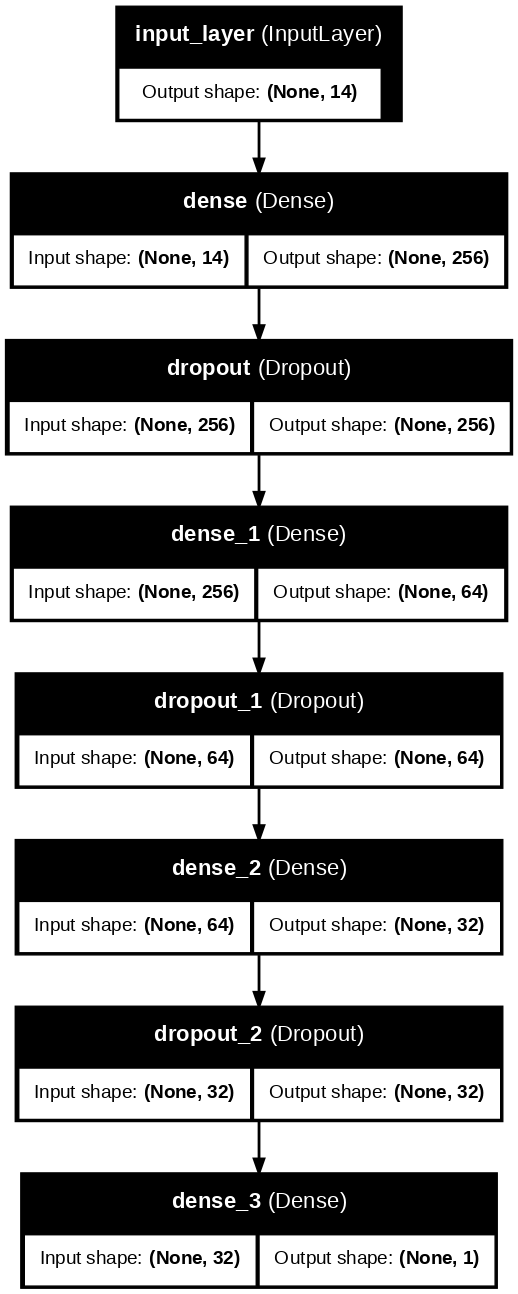

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(
    mlp_model.model,
    to_file="mlp_model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

# To display it directly in a notebook:
from IPython.display import Image
Image("mlp_model_architecture.png")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Accuracy: 0.9403


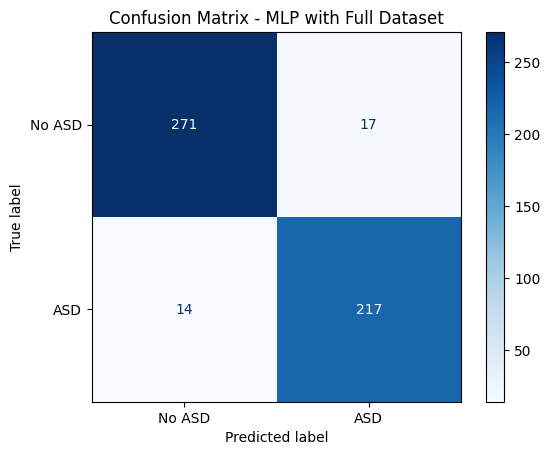

Classification Report:
              precision    recall  f1-score   support

      No ASD       0.95      0.94      0.95       288
         ASD       0.93      0.94      0.93       231

    accuracy                           0.94       519
   macro avg       0.94      0.94      0.94       519
weighted avg       0.94      0.94      0.94       519



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
mlp_model = MLPModel(
    input_data=x_vals,
    target_data=y_vals,
    test_size=0.2,
    epochs=100,
    batch_size=32,
    learning_rate=0.001,
    dropout_rate=0.7,
    model_seed = 4268,
    split_seed = 345712
)
# Train the model
mlp_model.train()

# Predictions
y_pred_mlp = (mlp_model.model.predict(mlp_model.X_test) > 0.5).astype(int).flatten()

# Accuracy
accuracy_mlp = accuracy_score(mlp_model.y_test, y_pred_mlp)
print(f"Test Accuracy: {accuracy_mlp:.4f}")

# Confusion Matrix
cm = confusion_matrix(mlp_model.y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No ASD", "ASD"])

# Plot Confusion Matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP with Full Dataset")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(mlp_model.y_test, y_pred_mlp, target_names=["No ASD", "ASD"]))